In [18]:
import re
import random
import pandas as pd
import hashlib

In [19]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.75) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [20]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Azure AI Search,212.622431,15.187316,14
AKS,214.413119,71.471040,3
Network Mapping,333.586346,15.885064,21
Lost in a Good Book,364.575511,18.228776,20
MS Identity Platform,646.656006,92.379429,7
Taxes,794.288316,79.428832,10
sklearn,856.618102,171.323620,5
Finance Junk,962.047890,120.255986,8
Search Engine Optimization,1016.870691,59.815923,17
Open Source/GitHub,1155.448436,50.236889,23


# Histogram

41004.54


<Axes: >

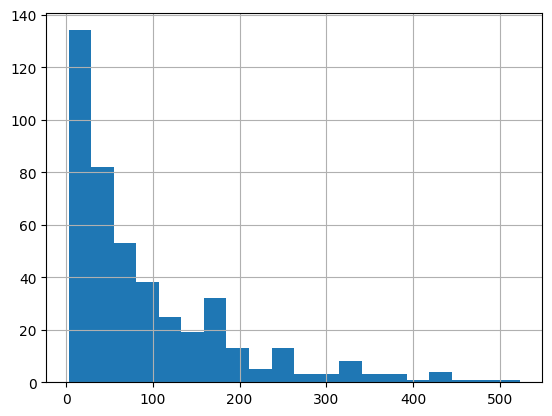

In [21]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [22]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [23]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [24]:
frequency = existing_cards['head'].value_counts(ascending=True)

existing_cards = pd.merge(
    left=existing_cards,
    right=frequency.rename('frequency'),
    left_on='head', right_index=True,
    how='left'
)
existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
existing_cards['age'] = existing_cards['age'] * -1


existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

Cards found: 442


# Focus on one header

In [25]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [26]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [27]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [28]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [29]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

## Age Sum

In [30]:
# n=4
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

## Age max

In [31]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [32]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)


In [33]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,oldest
106,AKS,Azure Container Apps is a fully managed Kubern...,333fbfd74901f0ea37fa70efee8504d7,-128.547850,71.471040,-128.547850,214.413119,0.780418,3,128.547850
222,AKS,Application scalability in AKS is the sole res...,dcea0b623cfcf77aefceed357cc1e1ce,-55.930697,71.471040,-128.547850,214.413119,0.780418,3,128.547850
328,AKS,Web App for Containers and Container Apps heal...,dcc021cdff518cc37a7dbefe205c30e8,-29.934572,71.471040,-128.547850,214.413119,0.780418,3,128.547850
64,sklearn,The classes in sklearn.neighbors can handle ei...,116b9942881e3e6fb092c4256fe3e256,-254.645334,171.323620,-254.645334,856.618102,0.013708,5,254.645334
184,sklearn,permutation_test_score: This function assesses...,ffe33ee61bc3c28e006c3d7bad803ea6,-190.128674,171.323620,-254.645334,856.618102,0.013708,5,254.645334
395,sklearn,The cv_results_ attribute contains useful info...,8a7a297394f51006e3ff94f439923c56,-175.316573,171.323620,-254.645334,856.618102,0.013708,5,254.645334
292,sklearn,When evaluating the resulting model it is impo...,84ceb3bed96b3bcffa7a6c0319dcfe13,-174.164112,171.323620,-254.645334,856.618102,0.013708,5,254.645334
65,sklearn,Data leakage occurs when information from the ...,12ebe5ce4aba16177ff0f112bd6d272f,-62.363409,171.323620,-254.645334,856.618102,0.013708,5,254.645334
104,MS Identity Platform,Authorization server - The Microsoft identity ...,a97445a5661ae54e36d4b6479e48e6da,-153.542049,92.379429,-153.542049,646.656006,0.701187,7,153.542049
220,MS Identity Platform,Resource owner - The resource owner in an auth...,f2fdca585a326c43df53333f7233874b,-147.370556,92.379429,-153.542049,646.656006,0.701187,7,153.542049


In [34]:
existing_cards.head(10)['age'].sum()

-1371.9438269967957